<a href="https://colab.research.google.com/github/mchangxe/mchangxe/blob/master/2024_MDE_Stable_Image_API_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MDE Image Generation Workshop 2024 01/02

Image - to - Image Workflows

Prepared by George Guida

Email: info@architag.co.uk

# Setup

Welcome. This notebook can be used to try out the Stable Image Services. This implementation can be used in your production environment if you are developing an application using the API.

New to colab? Just hit the play button on each of the cells and follow instructions.

You will need an account on https://platform.stability.ai/ to use the features.

Have fun and do great things.

In [ ]:
#@title Install requirements
from io import BytesIO
import IPython
import json
import os
from PIL import Image
import requests
import time
from google.colab import output

In [ ]:
#@title Connect to the Stability API

import getpass
# @markdown To get your API key visit https://platform.stability.ai/account/keys
STABILITY_KEY = getpass.getpass('Enter your API Key')



Enter your API Key··········


In [ ]:
#@title Define functions

def send_generation_request(
    host,
    params,
):
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    # Encode parameters
    files = {}
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

def send_async_generation_request(
    host,
    params,
):
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {STABILITY_KEY}"
    }

    # Encode parameters
    files = {}
    if "image" in params:
        image = params.pop("image")
        files = {"image": open(image, 'rb')}

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    # Process async response
    response_dict = json.loads(response.text)
    generation_id = response_dict.get("id", None)
    assert generation_id is not None, "Expected id in response"

    # Loop until result or timeout
    timeout = int(os.getenv("WORKER_TIMEOUT", 500))
    start = time.time()
    status_code = 202
    while status_code == 202:
        response = requests.get(
            f"{host}/result/{generation_id}",
            headers={
                **headers,
                "Accept": "image/*"
            },
        )

        if not response.ok:
            raise Exception(f"HTTP {response.status_code}: {response.text}")
        status_code = response.status_code
        time.sleep(10)
        if time.time() - start > timeout:
            raise Exception(f"Timeout after {timeout} seconds")

    return response

# Control

Stable Image editing services includes sketch:

- Sketch: This service offers an ideal solution for design projects that require brainstorming and frequent iterations. It upgrades rough hand-drawn sketches to refined outputs with precise control. For non-sketch images, it allows detailed manipulation of the final appearance by leveraging the contour lines and edges within the image. This service will use 3 credits.

See https://platform.stability.ai/docs/api-reference#tag/Control

Try these services out in the sections below. Check back in for regular updates.


Sending REST request to https://api.stability.ai/v2beta/stable-image/control/sketch...
Saved image edited_Sketch_03_6789704.jpeg


<IPython.core.display.Javascript object>

Original image:


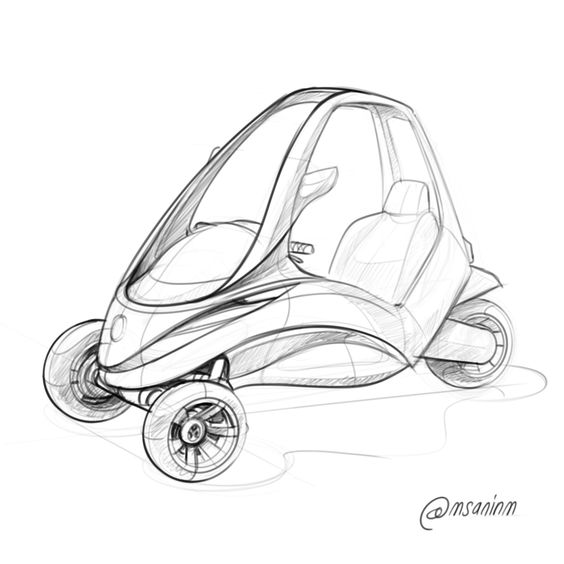

Result image:


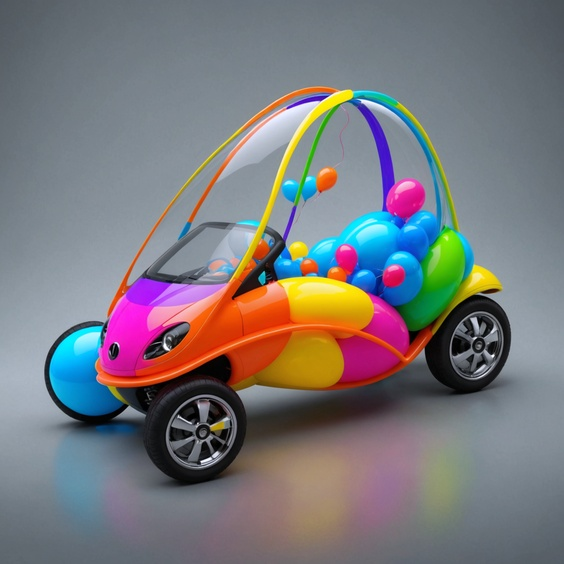

In [ ]:
#@title Sketch

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/Sketch_03.jpg" #@param {type:"string"}
prompt = "minimal futuristic car made of ballons with no wheels, vibrant colors " #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
control_strength = 0.85  #@param {type:"slider", min:0, max:1, step:0.05}
seed = 0 #@param {type:"integer"}
output_format = "jpeg" #@param ["webp", "jpeg", "png"]

host = f"https://api.stability.ai/v2beta/stable-image/control/sketch"

params = {
    "control_strength" : control_strength,
    "image" : image,
    "seed" : seed,
    "output_format": output_format,
    "prompt" : prompt,
    "negative_prompt" : negative_prompt,
}

response = send_generation_request(
    host,
    params
)

# Decode response
output_image = response.content
finish_reason = response.headers.get("finish-reason")
seed = response.headers.get("seed")

# Check for NSFW classification
if finish_reason == 'CONTENT_FILTERED':
    raise Warning("Generation failed NSFW classifier")

# Save and display result
filename, _ = os.path.splitext(os.path.basename(image))
edited = f"edited_{filename}_{seed}.{output_format}"
with open(edited, "wb") as f:
    f.write(output_image)
print(f"Saved image {edited}")

output.no_vertical_scroll()
print("Original image:")
IPython.display.display(Image.open(image))
print("Result image:")
IPython.display.display(Image.open(edited))

##Save image into Drive Folder (Optional!)

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = f"/content/drive/MyDrive/2024_MDE_Workshop/{filename}_{seed}.{output_format}"  # change path if you want
os.makedirs(os.path.dirname(file_path), exist_ok=True)

with open(file_path, "wb") as f:
    f.write(output_image)

print(f"Saved image to {file_path}")

Saved image to /content/drive/MyDrive/2024_MDE_Workshop/Sketch_03_6789704.jpeg
